In [4]:
import time
import os
import markov
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys
util_path = './utils'
sys.path.insert(0, util_path)
import preprocessing as pp
# from markov.api.model import ModelRecorder
# from markov.api.recording.experiments.integrations.keras.keras_auto_record import auto_record
# from markov.api.recording.integrations.keras.keras_auto_record import auto_record
# from markov.api.schemas.model_recording import ModelRecordingConfig, SingleTagInferenceRecord
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, log_loss, recall_score, precision_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
filepath = os.path.join(os.path.curdir, "Datasets", "master_dataset.csv")
df = pd.read_csv(filepath)
df.head()
len(df)

28768

In [7]:
df["processed_text"] = df['text'].apply(pp.process_text, model=1)
df.head(10)

,text,label_sexist,processed_text
0,"Damn, this writing was pretty chaotic",not sexist,damn writing pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,yeah apparently bunch misogynistic virgin one ...
2,How the FUCK is this woman still an MP!!!???,not sexist,fuck woman still mp
3,Understand. Know you're right. At same time I ...,not sexist,understand know youre right time know isnt eno...
4,Surprized they didn't stop and rape some women,not sexist,surprized didnt stop rape woman
5,yeah but in order to keep the benefit i have t...,not sexist,yeah order keep benefit good tommorow told cou...
6,Hahaha I just wish they would live their truth...,not sexist,hahaha wish would live truth cut shit wouldnt ...
7,head mod said she talked to him after he made ...,not sexist,head mod said talked made post wont tell anyon...
8,"just the inside of your wallet: cash, bank car...",sexist,inside wallet cash bank card credit card debit...
9,We most definitely did. I didn’t go too much i...,not sexist,definitely didnt go much detail happened put s...


In [8]:
class_notsexist, class_sexist = df['label_sexist'].value_counts()
class_notsexist, class_sexist
# # Separate class
class_s = df[df['label_sexist'] == "sexist"]
class_ns = df[df['label_sexist'] == "not sexist"]
print('class_sexist:', class_s.shape)
print('class_notsexist:', class_ns.shape)

class_sexist: (5831, 3)
class_notsexist: (22937, 3)


<AxesSubplot:title={'center':'count (target)'}>

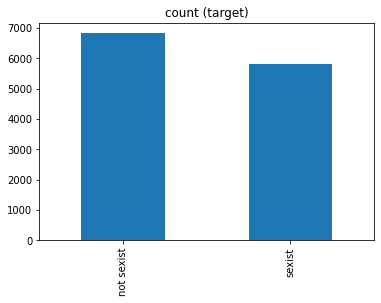

In [9]:
class_ns_under = class_ns.sample(class_sexist+1000)
df_under = pd.concat([class_ns_under, class_s], axis=0)
df_under['label_sexist'].value_counts().plot(kind='bar', title='count (target)')

In [10]:
tfidf = TfidfVectorizer()
tfidf_text_vec = tfidf.fit_transform(df_under.processed_text)

In [12]:
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(tfidf_text_vec, df_under['label_sexist'], test_size=0.2, train_size=0.8, random_state=5, shuffle=True)

In [ ]:
# from markov import Project, ProjectScope

# # Create a new project
# my_project = Project(
#     # project name
#     name="Final Project AI4SG",
#     # project description (optional)
#     description="Visualizing the model-1 and model-2",
#     # project visibility (optional; public by default)
#     project_scope=ProjectScope.PUBLIC,
# )

In [9]:
import markov

hyper_parameters = {"random_state":0,"n_estimators":10,"max_iter":100}
lrm = LogisticRegression(penalty='l2', random_state=0,max_iter=100,class_weight='balanced')



# Use the ExperimentRecorder constuctor provided by the MarkovML SDK
# to create a new experiment recorder
recorder_lr = markov.ExperimentRecorder(
    # Name of the experiment recording
    name="Model 1 Logistic Regression experiment",
    # Project associated with the experiment
    # project_id=my_project.project_id,
    project_id = "3GEEgreNQVvGxs",
    # Hyper-parameters used for model training
    hyper_parameters = {"random_state":0,"n_estimators":10,"max_iter":100},
    # Additional notes (optional)
    model_class=markov.ModelClass.TAGGING,
    notes="This is a experiment describing the model-1 Logistic Regression"
)

✔ Creating Model Model creation successful!
✔ Registering Hyper Parameter Recorder with Markov Backend. Recorder successfully registered.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/proj/3GEEgreNQVvGxs/experiments/hp-9VZQU7kpze6FoUJL77ciKwF]8;;\


In [12]:
with recorder_lr:
    lrm = lrm.fit(x_train_a, y_train_a,sample_weight=np.full(len(y_train_a),1))
    lrm_pred = lrm.predict(x_test_a)
    acc = accuracy_score(lrm_pred, y_test_a)
    recorder_lr.add_record({"accuracy": acc})
    cr = classification_report(y_test_a, lrm_pred)
    recorder_lr.add_record({"classification_report": cr})
    cm = confusion_matrix(lrm_pred, y_test_a)
    recorder_lr.add_record({"confusion_matrix": cm})
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, lrm_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, lrm_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result/model1", "task_a_cls_report_logistic_reg.csv"), index= True)

ℹ Starting recorder to track training data on markov backend.
⚠ Please wait while we send the remaining data to the markov backend... Could not send all QUEUE_MESSAGE_TYPEs to the markov server!
Accuracy: 78.72%
              precision    recall  f1-score   support

  not sexist       0.81      0.80      0.81      1401
      sexist       0.76      0.77      0.76      1132

    accuracy                           0.79      2533
   macro avg       0.78      0.79      0.79      2533
weighted avg       0.79      0.79      0.79      2533



In [13]:
import pickle

# save the model
filename = './result/model1/Logistic Regression/logistic_regression_model.sav'
pickle.dump(lrm, open(filename, 'wb'))

# load the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test_a, y_test_a)
print(result)

0.7872088432688512


In [14]:
def predict_sexism(text, model, tfidf, lemmatizer, stop_words):
    text = process_text(text, lemmatizer, stop_words)
    text_vec = tfidf.transform([text])
    prediction = model.predict(text_vec)
    return prediction[0]

# test the function
example_text = "I was told no woman who had children under the age of 6 had any business being outside the home."
pred = predict_sexism(example_text, loaded_model, tfidf, lemmatizer, stop_words)
print(pred) # should print 'not sexist' or 'sexist'


sexist


In [15]:
dict_data = {'actual': y_test_a, 'predicted': lrm_pred} ## see which variables to take from accuracy_score line in previous code block
df_markov = pd.DataFrame(data=dict_data)
df_markov.to_csv("./result/model1/Logistic Regression/recording_lr.csv")
df_markov.head()

# now just map the not sexist with 0 and sexist with 1

,actual,predicted
18043,not sexist,sexist
2332,not sexist,sexist
23724,sexist,sexist
17758,sexist,not sexist
1476,not sexist,sexist


In [16]:
from markov import EvaluationRecorder
evaluation_recorder_lr = EvaluationRecorder(
    name=f"Evaluating {recorder_lr.name}",
    notes=f"Evaluation of model1 using MarkovML",
    model_id=recorder_lr.model_id
)

evaluation_recorder_lr.register()

In [17]:
import os
import uuid

from markov.api.schemas.model_recording import SingleTagInferenceRecord

# create and register the recorder
filepath = os.path.join('./result/model1/Logistic Regression/recording_lr.csv')
with open(filepath) as f:
    for line in f:
        # Assign a unique identifier for individual records
        record_id = str(uuid.uuid4())
        tokens = line.strip('\n').split(',')
        record = SingleTagInferenceRecord(
            urid=record_id,
            inferred=tokens[2],
            actual=tokens[1],
            score=float(tokens[0])
        )
        evaluation_recorder_lr.add_record(record)
outcome = evaluation_recorder_lr.finish()
print(outcome)

Upload Progress : 100%|██████████| 3/3 [00:00<00:00,  3.54batch/s]


EvaluationRecordingFinishResponse(count=2533, recording_id='4iTwUc4aMV3se68yG5so7wN', return_code='OK', message='', run_id='wWHwNVNYfpeAzZwYvMh')


In [18]:
# Decision Tree

In [19]:
import markov

hyper_parameters = {"max_features":20}
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', max_features=20)


# Use the ExperimentRecorder constuctor provided by the MarkovML SDK
# to create a new experiment recorder
recorder_dt = markov.ExperimentRecorder(
    # Name of the experiment recording
   name="Model 1 Decision Tree experiment",
    # Project associated with the experiment
    # project_id=my_project.project_id,
    project_id = "3GEEgreNQVvGxs",
    # Hyper-parameters used for model training
    hyper_parameters = {"max_features":20},
    # Additional notes (optional)
    model_class=markov.ModelClass.TAGGING,
    notes="This is a experiment describing the model-1 Decision Tree"
)




✔ Creating Model Model creation successful!
✔ Registering Hyper Parameter Recorder with Markov Backend. Recorder successfully registered.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/proj/3GEEgreNQVvGxs/experiments/hp-kijfgCCDSi3qJCu4hrtTpbf]8;;\


In [20]:
with recorder_dt:
    dt_clf = dt_clf.fit(x_train_a, y_train_a)
    dt_pred = dt_clf.predict(x_test_a)
    acc = accuracy_score(dt_pred, y_test_a)
    recorder_dt.add_record({"accuracy": acc})
    cr = classification_report(y_test_a, dt_pred)
    recorder_dt.add_record({"classification_report": cr})
    cm = confusion_matrix(dt_pred, y_test_a)
    recorder_dt.add_record({"confusion_matrix": cm})
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, dt_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, dt_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result/model1/Decision Tree/", "task_a_cls_report_logistic_decision_tree.csv"), index= True)

ℹ Starting recorder to track training data on markov backend.
⚠ Please wait while we send the remaining data to the markov backend... Could not send all QUEUE_MESSAGE_TYPEs to the markov server!
Accuracy: 63.09%
              precision    recall  f1-score   support

  not sexist       0.68      0.63      0.65      1401
      sexist       0.58      0.63      0.60      1132

    accuracy                           0.63      2533
   macro avg       0.63      0.63      0.63      2533
weighted avg       0.63      0.63      0.63      2533



In [21]:
import pickle

# save the model
filename = './result/model1/Decision Tree/Decision_Tree_model.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

# load the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test_a, y_test_a)
print(result)

0.6308724832214765


In [22]:
def predict_sexism(text, model, tfidf, lemmatizer, stop_words):
    text = process_text(text, lemmatizer, stop_words)
    text_vec = tfidf.transform([text])
    prediction = model.predict(text_vec)
    return prediction[0]

# test the function
example_text = "I was told no woman who had children under the age of 6 had any business being outside the home."
pred = predict_sexism(example_text, loaded_model, tfidf, lemmatizer, stop_words)
print(pred) # should print 'not sexist' or 'sexist'


not sexist


In [23]:
dict_data = {'actual': y_test_a, 'predicted': dt_pred} ## see which variables to take from accuracy_score line in previous code block
df_markov = pd.DataFrame(data=dict_data)
df_markov.to_csv("./result/model1/Decision Tree/recording_dt.csv")
df_markov.head()

# now just map the not sexist with 0 and sexist with 1

,actual,predicted
18043,not sexist,sexist
2332,not sexist,not sexist
23724,sexist,sexist
17758,sexist,not sexist
1476,not sexist,not sexist


In [24]:
from markov import EvaluationRecorder
evaluation_recorder_dt = EvaluationRecorder(
    name=f"Evaluating {recorder_dt.name}",
    notes=f"Evaluation of model1 using MarkovML",
    model_id=recorder_dt.model_id
)

evaluation_recorder_dt.register()

In [25]:
import os
import uuid

from markov.api.schemas.model_recording import SingleTagInferenceRecord

# create and register the recorder
filepath = os.path.join('./result/model1/Decision Tree/recording_dt.csv')
with open(filepath) as f:
    for line in f:
        # Assign a unique identifier for individual records
        record_id = str(uuid.uuid4())
        tokens = line.strip('\n').split(',')
        record = SingleTagInferenceRecord(
            urid=record_id,
            inferred=tokens[2],
            actual=tokens[1],
            score=float(tokens[0])
        )
        evaluation_recorder_dt.add_record(record)
outcome = evaluation_recorder_dt.finish()
print(outcome)

Upload Progress : 100%|██████████| 3/3 [00:01<00:00,  2.34batch/s]


EvaluationRecordingFinishResponse(count=2533, recording_id='5BHrMJG8fS3W9ZUaTGPjSoU', return_code='OK', message='', run_id='h5xSBKCz773UjzkS7UW')


In [ ]:
# Xgboost Model

In [27]:


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_a_enc = le.fit_transform(y_train_a)
y_test_a_enc = le.fit_transform(y_test_a)

In [33]:
import markov

hyper_parameters = {"random_state":5}
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", random_state=5)


# Use the ExperimentRecorder constuctor provided by the MarkovML SDK
# to create a new experiment recorder
recorder_xgb = markov.ExperimentRecorder(
    # Name of the experiment recording
   name="Model 1 Xgboost experiment",
    # Project associated with the experiment
    # project_id=my_project.project_id,
    project_id = "3GEEgreNQVvGxs",
    # Hyper-parameters used for model training
   hyper_parameters = {"random_state":5},
    # Additional notes (optional)
    model_class=markov.ModelClass.TAGGING,
    notes="This is a experiment describing the model-1 Xgboost"
)




✔ Creating Model Model creation successful!
✔ Registering Hyper Parameter Recorder with Markov Backend. Recorder successfully registered.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/proj/3GEEgreNQVvGxs/experiments/hp-7i6amaWRFg2vbm3gYpfmsSX]8;;\


In [34]:
with recorder_xgb:
    xgb_clf.fit(x_train_a, y_train_a_enc)
    y_pred = xgb_clf.predict(x_test_a)
    y_pred_enc = le.fit_transform(y_pred)
    acc = accuracy_score(y_pred_enc, y_test_a_enc)
    recorder_xgb.add_record({"accuracy": acc})
    cr = classification_report(y_pred_enc, y_test_a_enc)
    recorder_xgb.add_record({"classification_report": cr})
    cm = confusion_matrix(y_pred_enc, y_test_a_enc)
    recorder_xgb.add_record({"confusion_matrix": cm})
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a_enc, y_pred_enc))
clsf_report = pd.DataFrame(classification_report(y_test_a_enc, y_pred_enc, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result/model1/Xgboost/", "task_a_cls_report_xgboost.csv"), index= True)

ℹ Starting recorder to track training data on markov backend.
⚠ Please wait while we send the remaining data to the markov backend... Could not send all QUEUE_MESSAGE_TYPEs to the markov server!
Accuracy: 79.31%
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1401
           1       0.76      0.78      0.77      1132

    accuracy                           0.79      2533
   macro avg       0.79      0.79      0.79      2533
weighted avg       0.79      0.79      0.79      2533



In [39]:
import pickle

# save the model
filename = './result/model1/Xgboost/Xgboost_model.pkl'
pickle.dump(xgb_clf, open(filename, 'wb'))

# load the model
loaded_model = pickle.load(open(filename, 'rb'))
# make predictions with the loaded model
y_pred = loaded_model.predict(x_test_a)
y_pred_enc = le.fit_transform(y_pred)

# evaluate the loaded model
acc = accuracy_score(y_pred_enc, y_test_a_enc)
print("Accuracy:", acc)

Accuracy: 0.7931306750888275


In [40]:
def predict_sexism(text, model, tfidf, lemmatizer, stop_words):
    text = process_text(text, lemmatizer, stop_words)
    text_vec = tfidf.transform([text])
    prediction = model.predict(text_vec)
    return prediction[0]

# test the function
example_text = "I was told no woman who had children under the age of 6 had any business being outside the home."
pred = predict_sexism(example_text, loaded_model, tfidf, lemmatizer, stop_words)
print(pred) # should print 'not sexist' or 'sexist'


1


In [41]:
dict_data = {'actual': y_test_a_enc, 'predicted': y_pred_enc}
df_xgb = pd.DataFrame(data=dict_data)
# save the dataframe to a CSV file
df_xgb.to_csv("./result/model1/Xgboost/recording_xgb.csv")

# display the first few rows of the dataframe
df_xgb.head()
# now just map the not sexist with 0 and sexist with 1

,actual,predicted
0,0,1
1,0,1
2,1,1
3,1,1
4,0,1


In [42]:
from markov import EvaluationRecorder
evaluation_recorder_xgb = EvaluationRecorder(
    name=f"Evaluating {recorder_xgb.name}",
    notes=f"Evaluation of model1 using MarkovML",
    model_id=recorder_xgb.model_id
)

evaluation_recorder_xgb.register()

In [43]:
import os
import uuid

from markov.api.schemas.model_recording import SingleTagInferenceRecord

# create and register the recorder
filepath = os.path.join('./result/model1/Xgboost/recording_xgb.csv')
with open(filepath) as f:
    for line in f:
        # Assign a unique identifier for individual records
        record_id = str(uuid.uuid4())
        tokens = line.strip('\n').split(',')
        record = SingleTagInferenceRecord(
            urid=record_id,
            inferred=tokens[2],
            actual=tokens[1],
            score=float(tokens[0])
        )
        evaluation_recorder_xgb.add_record(record)
outcome = evaluation_recorder_xgb.finish()
print(outcome)

Upload Progress : 100%|██████████| 3/3 [00:00<00:00,  4.76batch/s]


EvaluationRecordingFinishResponse(count=2533, recording_id='9LNQfVnKRHwDL8vh5ispDQg', return_code='OK', message='', run_id='Vnv2ESzVd4TFbRey8qr')


In [44]:
#random forest

In [14]:
import markov

hyper_parameters = {}
rf_clf = RandomForestClassifier()


# Use the ExperimentRecorder constuctor provided by the MarkovML SDK
# to create a new experiment recorder
recorder_rf = markov.ExperimentRecorder(
    # Name of the experiment recording
   name="Model-1 Random Forest experiment",
    # Project associated with the experiment
    # project_id=my_project.project_id,
    project_id = "3GEEgreNQVvGxs",
    # Hyper-parameters used for model training
   hyper_parameters = {},
    # Additional notes (optional)
    model_class=markov.ModelClass.TAGGING,
    notes="This is a experiment describing the model-1 Random Forest"
)




✔ Creating Model Model creation successful!
✔ Registering Hyper Parameter Recorder with Markov Backend. Recorder successfully registered.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/proj/3GEEgreNQVvGxs/experiments/hp-4cyFFgRprjPgnpPEeAcxEjN]8;;\


In [15]:
with recorder_rf:
    rf_clf.fit(x_train_a, y_train_a)
    rf_pred = rf_clf.predict(x_test_a)
    acc = accuracy_score(rf_pred, y_test_a)
    recorder_rf.add_record({"accuracy": acc})
    cr = classification_report(y_test_a, rf_pred)
    recorder_rf.add_record({"classification_report": cr})
    cm = confusion_matrix(y_test_a, rf_pred)
    recorder_rf.add_record({"confusion_matrix": cm})
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, rf_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, rf_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result/model1/Random Forest/", "task_a_cls_report_random_forest.csv"), index= True)

ℹ Starting recorder to track training data on markov backend.
⚠ Please wait while we send the remaining data to the markov backend... Could not send all QUEUE_MESSAGE_TYPEs to the markov server!
Accuracy: 81.25%
              precision    recall  f1-score   support

  not sexist       0.84      0.82      0.83      1401
      sexist       0.78      0.80      0.79      1132

    accuracy                           0.81      2533
   macro avg       0.81      0.81      0.81      2533
weighted avg       0.81      0.81      0.81      2533



In [16]:
import pickle

# save the model
filename = './result/model1/Random Forest/RandomForest_model.pkl'
pickle.dump(rf_clf, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

# make predictions with the loaded model
rf_pred = loaded_model.predict(x_test_a)

# evaluate the loaded model
acc = accuracy_score(rf_pred, y_test_a)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, rf_pred))

Accuracy: 81.25%
              precision    recall  f1-score   support

  not sexist       0.84      0.82      0.83      1401
      sexist       0.78      0.80      0.79      1132

    accuracy                           0.81      2533
   macro avg       0.81      0.81      0.81      2533
weighted avg       0.81      0.81      0.81      2533



In [17]:
def predict_sexism(text, model, tfidf, lemmatizer, stop_words):
    text = process_text(text, lemmatizer, stop_words)
    text_vec = tfidf.transform([text])
    prediction = model.predict(text_vec)
    return prediction[0]

# test the function
example_text = "I was told no woman who had children under the age of 6 had any business being outside the home."
pred = predict_sexism(example_text, loaded_model, tfidf, lemmatizer, stop_words)
print(pred) # should print 'not sexist' or 'sexist'


sexist


In [18]:
# create a dataframe with actual and predicted values
dict_data = {'actual': y_test_a, 'predicted': rf_pred}
df_rf = pd.DataFrame(data=dict_data)

# save the dataframe to a CSV file
df_rf.to_csv("./result/model1/Random Forest/recording_rf.csv")

# display the first few rows of the dataframe
df_rf.head()

,actual,predicted
25687,not sexist,not sexist
1163,not sexist,not sexist
23724,sexist,sexist
17758,sexist,sexist
11829,not sexist,not sexist


In [19]:
from markov import EvaluationRecorder
evaluation_recorder_rf = EvaluationRecorder(
    name=f"Evaluating {recorder_rf.name}",
    notes=f"Evaluation of model1 using MarkovML",
    model_id=recorder_rf.model_id
)

evaluation_recorder_rf.register()

In [20]:
import os
import uuid

from markov.api.schemas.model_recording import SingleTagInferenceRecord

# create and register the recorder
filepath = os.path.join('./result/model1/Random Forest/recording_rf.csv')
with open(filepath) as f:
    for line in f:
        # Assign a unique identifier for individual records
        record_id = str(uuid.uuid4())
        tokens = line.strip('\n').split(',')
        record = SingleTagInferenceRecord(
            urid=record_id,
            inferred=tokens[2],
            actual=tokens[1],
            score=float(tokens[0])
        )
        evaluation_recorder_rf.add_record(record)
outcome = evaluation_recorder_rf.finish()
print(outcome)

Upload Progress : 100%|██████████| 3/3 [00:00<00:00,  3.11batch/s]


EvaluationRecordingFinishResponse(count=2533, recording_id='4g4AUYNE45oMH7G7PLTPGoB', return_code='OK', message='', run_id='3CGLd8GpbsW34EM84AC')
